# Online non-linear regression with corrupted observations

In [6]:
import jax
import optax
import numpy as np
import pandas as pd
import seaborn as sns
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt

from bayes_opt import BayesianOptimization
from functools import partial
from rebayes_mini import callbacks
from rebayes_mini.methods import replay_sgd
from rebayes_mini.methods import gauss_filter as gf
from rebayes_mini.methods import robust_filter as rfilter
from rebayes_mini.methods import generalised_bayes_filter as gbfilter

In [7]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

plt.rcParams["font.size"] = 18

cmap = {
    "EKF-IW": "crimson",
    "WLF-IMQ": "dodgerblue",
    "EKF": "lightseagreen",
    "WLF-MD": "gold", # TODO: make more o-paco
    "OGD": "blueviolet",
    "EKF-B": "darkorange",
}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data-generating process

In [8]:
c1, c2, c3, c4 = 1 / 5, -10, 1.0, 1.0
def f(x):
    return c1 * x + c2 * jnp.cos(c3 * jnp.pi * x) + c4 * x ** 3


def sample_observations_grid(
    key, f, n_obs, xmin, xmax, x_noise=0.1, y_noise=3.0, p_corrupt=0.1, ycorr_max=100,
    is_sorted=False
):
    key_x, key_y, key_shuffle, key_corrupted = jax.random.split(key, 4)
    
    key_cchoice, key_cval = jax.random.split(key_corrupted)
    is_corrupted = jax.random.bernoulli(key_cchoice, p=p_corrupt, shape=(n_obs,))
    ycorr = jax.random.uniform(key_cval, (n_obs,), minval=-ycorr_max, maxval=ycorr_max)
    
    y_noise = jax.random.normal(key_y, (n_obs,)) * y_noise
    x = jax.random.uniform(key_x, (n_obs,), minval=xmin, maxval=xmax)
    y = f(x) + y_noise
    
    y = y * (1 - is_corrupted) + ycorr * is_corrupted
    
    X = jnp.c_[x, y]
    shuffled_ixs = jax.random.permutation(key_shuffle, jnp.arange(n_obs))
    
    if is_sorted:
        ixs_sort = jnp.argsort(x)
        x, y = jnp.array(X[ixs_sort, :].T)
    
    return x, y

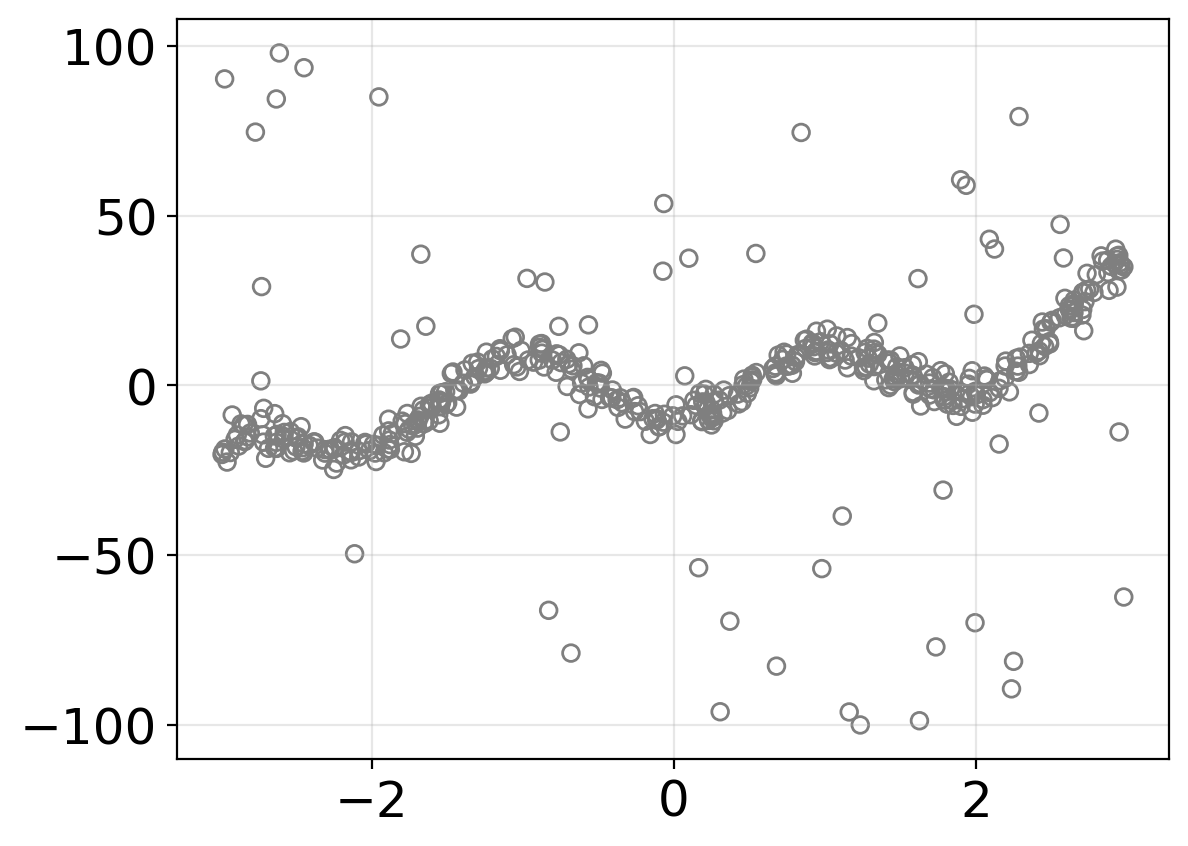

In [129]:
key = jax.random.PRNGKey(314)
key_train, key_sample_obs, key_eval = jax.random.split(key, 3)

n_obs = 500
xmin, xmax = -3, 3
sigma_y = 3.0
ycorrupted = 100

is_sorted = True
model_str = "dgen" # "mlp" or "dgen"

is_sorted_str = "sorted" if is_sorted else "unsorted"
x, y = sample_observations_grid(
    key_sample_obs, f, n_obs, xmin, xmax, x_noise=0.2, y_noise=sigma_y, p_corrupt=0.15,
    ycorr_max=ycorrupted, is_sorted=is_sorted
)
xtest = jnp.linspace(x.min(), x.max(), n_obs)
ytest = f(xtest)
plt.scatter(x, y, edgecolors="tab:gray", color="none")
plt.grid(alpha=0.3)

## Filtering

In [130]:
def callback_fn(bel, bel_pred, y, x, applyfn):
    yhat = applyfn(bel_pred.mean, x[None])
    return yhat

In [131]:
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(10)(x)
        x = nn.relu(x)
        x = nn.Dense(10)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x
    

class DGenFn(nn.Module):
    """
    True (non-noisy) data-generating process
    """
    init_var: float = nn.initializers.normal()
        
    @nn.compact
    def __call__(self, x):
        c1 = self.param("c1", self.init_var, (1,))
        c2 = self.param("c2", self.init_var, (1,))
        c3 = self.param("c3", self.init_var, (1,))
        c4 = self.param("c4", self.init_var, (1,))
        
        return c1 * x + c2 * jnp.cos(c3 * jnp.pi * x) + c4 * x ** 3

    
def latent_fn(x): return x

if model_str == "mlp":
    model = MLP()
elif model_str == "dgen":
    model = DGenFn()
else:
    raise ValueError("Model type no avaialble")

### Setup
Parameters shared for all methods

In [132]:
from jax.flatten_util import ravel_pytree

In [133]:
dynamics_covariance = 1e-4
observation_covariance = 1.0

cov_init = 1.0
params_init = model.init(key_train, x[:, None])

n_params, _ = ravel_pytree(params_init)
n_params = len(n_params)
Q = jnp.eye(n_params) * dynamics_covariance


### Extended Kalman Filter

In [134]:
def filter_ekf(log_lr):
    lr = np.exp(log_lr)
    
    agent = gf.ExtendedKalmanFilter(
            latent_fn, model.apply, dynamics_covariance=Q,
            observation_covariance=observation_covariance * jnp.eye(1),
        )
    
    bel_init = agent.init_bel(params_init, cov=lr)
    callback = partial(callback_fn, applyfn=agent.vobs_fn)
    bel, yhat_pp = agent.scan(bel_init, y, x[:, None], callback_fn=callback)
    out = (agent, bel)
    
    return yhat_pp.squeeze(), out


def opt_step(log_lr):
    res = -jnp.power(filter_ekf(log_lr)[0] - y, 2)
    res = jnp.median(res)
    if np.isnan(res):
        res = -1e+6
    
    return res

In [135]:
%%time
bo = BayesianOptimization(
    opt_step,
    pbounds={
        "log_lr": (-5, 0),
    },
    verbose=1,
    random_state=314,
    allow_duplicate_points=True
)

bo.maximize(init_points=10)

|   iter    |  target   |  log_lr   |
-------------------------------------
| 2         | -30.56    | -2.057    |
| 3         | -23.91    | -3.675    |
| 5         | -16.96    | -0.41     |
CPU times: user 2min 44s, sys: 2min 58s, total: 5min 43s
Wall time: 12 s


In [136]:
%%time
log_lr = bo.max["params"]["log_lr"]
lr_ekf = np.exp(log_lr)

yhat_pp_ekf, (agent_ekf, bel_ekf) = filter_ekf(log_lr)
yhat_ekf = agent_ekf.vobs_fn(bel_ekf.mean, xtest[:, None]).ravel()

CPU times: user 338 ms, sys: 12.4 ms, total: 350 ms
Wall time: 281 ms


### Robust Extended Kalman Filter

In [137]:
def filter_rkf(log_lr, noise_scaling):
    lr = np.exp(log_lr)
    agent_rekf = rfilter.ExtendedKalmanFilterInverseWishart(
        latent_fn, model.apply, dynamics_covariance=Q,
        prior_observation_covariance=observation_covariance * jnp.eye(1),
        noise_scaling=noise_scaling,
        n_inner=2
    )
    
    bel_init = agent_rekf.init_bel(params_init, cov=lr)
    callback = partial(callback_fn, applyfn=agent_rekf.vobs_fn)
    bel_rekf, yhat_pp = agent_rekf.scan(bel_init, y, x[:, None], callback_fn=callback)
    out = (agent_rekf, bel_rekf)
    
    return yhat_pp.squeeze(), out

def opt_step(log_lr, noise_scaling):
    res = -jnp.power(filter_rkf(log_lr, noise_scaling)[0] - y, 2)
    res = jnp.median(res)
    
    if np.isnan(res):
        res = -1e+6
    
    return res

In [138]:
%%time
bo = BayesianOptimization(
    opt_step,
    pbounds={
        "log_lr": (-5, 0),
        "noise_scaling": (1e-6, 20)
    },
    verbose=1,
    random_state=314,
    allow_duplicate_points=True
)

bo.maximize(init_points=10)

|   iter    |  target   |  log_lr   | noise_... |
-------------------------------------------------
| 3         | -8.279    | -0.41     | 16.55     |
| 20        | -8.174    | -1.048    | 16.94     |
| 24        | -8.106    | -0.9866   | 16.0      |
CPU times: user 2min 43s, sys: 2min 55s, total: 5min 38s
Wall time: 17.3 s


In [139]:
%%time
noise_scaling = bo.max["params"]["noise_scaling"]
log_lr = bo.max["params"]["log_lr"]
lr_rkef = np.exp(log_lr)

yhat_pp_rekf, (agent_rekf, bel_rekf) = filter_rkf(log_lr, noise_scaling)
yhat_rekf = agent_rekf.vobs_fn(bel_rekf.mean, xtest[:, None]).ravel()

CPU times: user 407 ms, sys: 25.8 ms, total: 432 ms
Wall time: 347 ms


### Inverse Multi-quadratic filter

In [140]:
def filter_imqf(log_lr, soft_threshold):
    lr = np.exp(log_lr)
    agent_imq = gbfilter.IMQFilter(
        model.apply, dynamics_covariance=Q,
        observation_covariance=observation_covariance,
        soft_threshold=soft_threshold
    )

    bel_init = agent_imq.init_bel(params_init, cov=lr)
    callback = partial(callback_fn, applyfn=agent_imq.link_fn)
    bel_imq, yhat_pp = agent_imq.scan(bel_init, y, x[:, None], callback_fn=callback)
    out = (agent_imq, bel_imq)
    return yhat_pp.squeeze(), out


def opt_step(log_lr, soft_threshold):
    res = -jnp.power(filter_imqf(log_lr, soft_threshold)[0] - y, 2)
    res = jnp.median(res)
    
    if np.isnan(res):
        res = -1e+6
    
    return res

In [141]:
%%time
bo = BayesianOptimization(
    opt_step,
    pbounds={
        "log_lr": (-5, 0),
        "soft_threshold": (1e-6, 20),
    },
    verbose=1,
    random_state=314,
    allow_duplicate_points=True
)

bo.maximize(init_points=10)

|   iter    |  target   |  log_lr   | soft_t... |
-------------------------------------------------
| 2         | -11.61    | -3.675    | 15.66     |
| 3         | -7.972    | -0.41     | 16.55     |
| 31        | -7.901    | -0.344    | 17.11     |
CPU times: user 2min 39s, sys: 2min 55s, total: 5min 35s
Wall time: 11.3 s


In [142]:
%%time
soft_threshold = bo.max["params"]["soft_threshold"]
log_lr = bo.max["params"]["log_lr"]
lr_imq = np.exp(log_lr)

yhat_pp_imq, (agent_imq, bel_imq) = filter_imqf(log_lr, soft_threshold)
yhat_imq = agent_imq.link_fn(bel_imq.mean, xtest[:, None]).ravel()

CPU times: user 331 ms, sys: 34.3 ms, total: 366 ms
Wall time: 286 ms


## Weighted-likelihood filter / Mahalanobis distance

In [143]:
def filter_mah_ekf(log_lr, threshold):
    lr = np.exp(log_lr)
    agent_mekf = rfilter.ExtendedKalmanFilterMD(
        latent_fn, model.apply,
        dynamics_covariance=Q,
        observation_covariance=observation_covariance * jnp.eye(1),
        threshold=threshold
    )
    
    bel_init = agent_mekf.init_bel(params_init, cov=lr)
    callback = partial(callback_fn, applyfn=agent_mekf.vobs_fn)
    
    bel_mekf, yhat_pp = agent_mekf.scan(bel_init, y, x[:, None], callback_fn=callback)
    out = (agent_mekf, bel_mekf)
    return yhat_pp.squeeze(), out


def opt_step(log_lr, threshold):
    res = -jnp.power(filter_mah_ekf(log_lr, threshold)[0] - y, 2)
    res = jnp.median(res)
    if np.isnan(res):
        res = -1e+6
    
    return res

In [144]:
%%time
bo = BayesianOptimization(
    opt_step,
    pbounds={
        "log_lr": (-5, 0),
        "threshold": (1e-6, 20)
    },
    verbose=1,
    random_state=314,
    allow_duplicate_points=True
)

bo.maximize(init_points=10)

|   iter    |  target   |  log_lr   | threshold |
-------------------------------------------------
| 11        | -9.584    | -1.611    | 14.12     |
| 13        | -8.787    | 0.0       | 20.0      |
| 28        | -8.668    | -0.02403  | 10.68     |
CPU times: user 2min 38s, sys: 2min 52s, total: 5min 30s
Wall time: 12.7 s


In [145]:
%%time
threshold = bo.max["params"]["threshold"]
log_lr = bo.max["params"]["log_lr"]
lr_mekf = np.exp(log_lr)

yhat_pp_mekf, (agent_mekf, bel_mekf) = filter_mah_ekf(log_lr, threshold)
yhat_mekf = agent_mekf.vobs_fn(bel_mekf.mean, xtest[:, None]).ravel()

CPU times: user 344 ms, sys: 7.02 ms, total: 351 ms
Wall time: 287 ms


## Wang 2018 --- outlier EKF

In [146]:
def filter_oekf(log_lr, alpha, beta):
    """
    Outlier ekf
    """
    lr = np.exp(log_lr)
    agent_wang2018 = rfilter.ExtendedKalmanFilterBernoulli(
        latent_fn, model.apply,
        dynamics_covariance=Q,
        observation_covariance=observation_covariance * jnp.eye(1),
        alpha=alpha,
        beta=beta,
        tol_inlier=1e-7,
        # tol_inner=1e-3 # refactor
        n_inner=2
    )
    
    bel_init = agent_wang2018.init_bel(params_init, cov=lr)
    callback = partial(callback_fn, applyfn=agent_wang2018.vobs_fn)
    
    bel_oekf, yhat_pp = agent_wang2018.scan(bel_init, y, x[:, None], callback_fn=callback)
    out = (agent_wang2018, bel_oekf)
    return yhat_pp.squeeze(), out


def opt_step(log_lr, alpha, beta):
    res = -jnp.power(filter_oekf(log_lr, alpha, beta)[0] - y, 2)
    res = jnp.median(res)
    if np.isnan(res):
        res = -1e+6
    
    return res

In [147]:
%%time
bo = BayesianOptimization(
    opt_step,
    pbounds={
        "log_lr": (-5, 0),
        "alpha": (0.0, 5.0),
        "beta": (0.0, 5.0)
    },
    random_state=314,
    verbose=1
)
bo.maximize(init_points=10)

|   iter    |  target   |   alpha   |   beta    |  log_lr   |
-------------------------------------------------------------
| 3         | -51.91    | 3.64      | 1.302     | -0.4412   |
| 13        | -48.03    | 4.245     | 1.659     | -0.6165   |
| 19        | -31.57    | 4.318     | 1.567     | -0.8191   |
| 25        | -29.91    | 4.343     | 1.47      | -0.7641   |
| 34        | -29.3     | 4.423     | 1.522     | -0.7606   |
CPU times: user 2min 56s, sys: 2min 55s, total: 5min 51s
Wall time: 26.9 s


In [148]:
%%time
log_lr = bo.max["params"]["log_lr"]
lr_oekf = np.exp(log_lr)
alpha = bo.max["params"]["alpha"]
beta = bo.max["params"]["beta"]

yhat_pp_moekf, (agent_oekf, bel_oekf) = filter_oekf(log_lr, alpha, beta)
yhat_oekf = agent_oekf.vobs_fn(bel_oekf.mean, xtest[:, None]).ravel()

CPU times: user 792 ms, sys: 8.24 ms, total: 800 ms
Wall time: 676 ms


## Online gradient descent

In [149]:
def lossfn(params, counter, x, y, applyfn):
    yhat = applyfn(params, x)
    return jnp.sum(counter * (y - yhat) ** 2) / counter.sum()


def filter_ogd(log_lr, n_inner):
    lr = np.exp(log_lr)
    n_inner = int(n_inner)
    agent = replay_sgd.FifoSGD(
        model.apply,
        lossfn,
        optax.adam(lr),
        buffer_size=1,
        dim_features=1,
        dim_output=1,
        n_inner=n_inner,
    )
    
    bel_init = agent.init_bel(params_init)
    callback = partial(callback_fn, applyfn=agent.apply_fn)
    
    bel, yhat_pp = agent.scan(bel_init, y, x[:, None], callback_fn=callback)
    out = (agent, bel)
    return yhat_pp.squeeze(), out



def opt_step(log_lr, n_inner):
    res = -jnp.power(filter_ogd(log_lr, n_inner)[0] - y, 2)
    res = jnp.median(res)
    if np.isnan(res):
        res = -1e+6
    
    return res

In [150]:
%%time
bo = BayesianOptimization(
    opt_step,
    pbounds={
        "log_lr": (-5, 0),
        "n_inner": (1, 10)
    },
    verbose=1,
    random_state=314,
    allow_duplicate_points=True
)

bo.maximize(init_points=10)

|   iter    |  target   |  log_lr   |  n_inner  |
-------------------------------------------------
| 2         | -38.89    | -3.675    | 8.049     |
| 3         | -37.07    | -0.41     | 8.446     |
| 4         | -35.7     | -1.36     | 3.344     |
| 8         | -28.43    | -0.7996   | 3.504     |
| 10        | -27.88    | -2.076    | 6.231     |
| 22        | -25.06    | -1.42     | 8.064     |
| 27        | -20.64    | -3.077    | 7.058     |
CPU times: user 2min 50s, sys: 2min 56s, total: 5min 47s
Wall time: 21.9 s


In [151]:
%%time
n_inner = int(bo.max["params"]["n_inner"])
log_lr = bo.max["params"]["log_lr"]
lr_ogd = np.exp(log_lr)

yhat_pp_ogd, (agent_ogd, bel_ogd) = filter_ogd(log_lr, n_inner)

CPU times: user 610 ms, sys: 2.67 ms, total: 612 ms
Wall time: 540 ms


# Plots

In [152]:
pp_elements = {
    "EKF": yhat_pp_ekf,
    "EKF-IW": yhat_pp_rekf,
    "WLF-MD": yhat_pp_mekf,
    "WLF-IMQ": yhat_pp_imq,
    "OGD": yhat_pp_ogd,
    "EKF-B": yhat_pp_moekf,
}

pp_elements = jax.tree_map(lambda x: np.squeeze(np.array(x)), pp_elements)

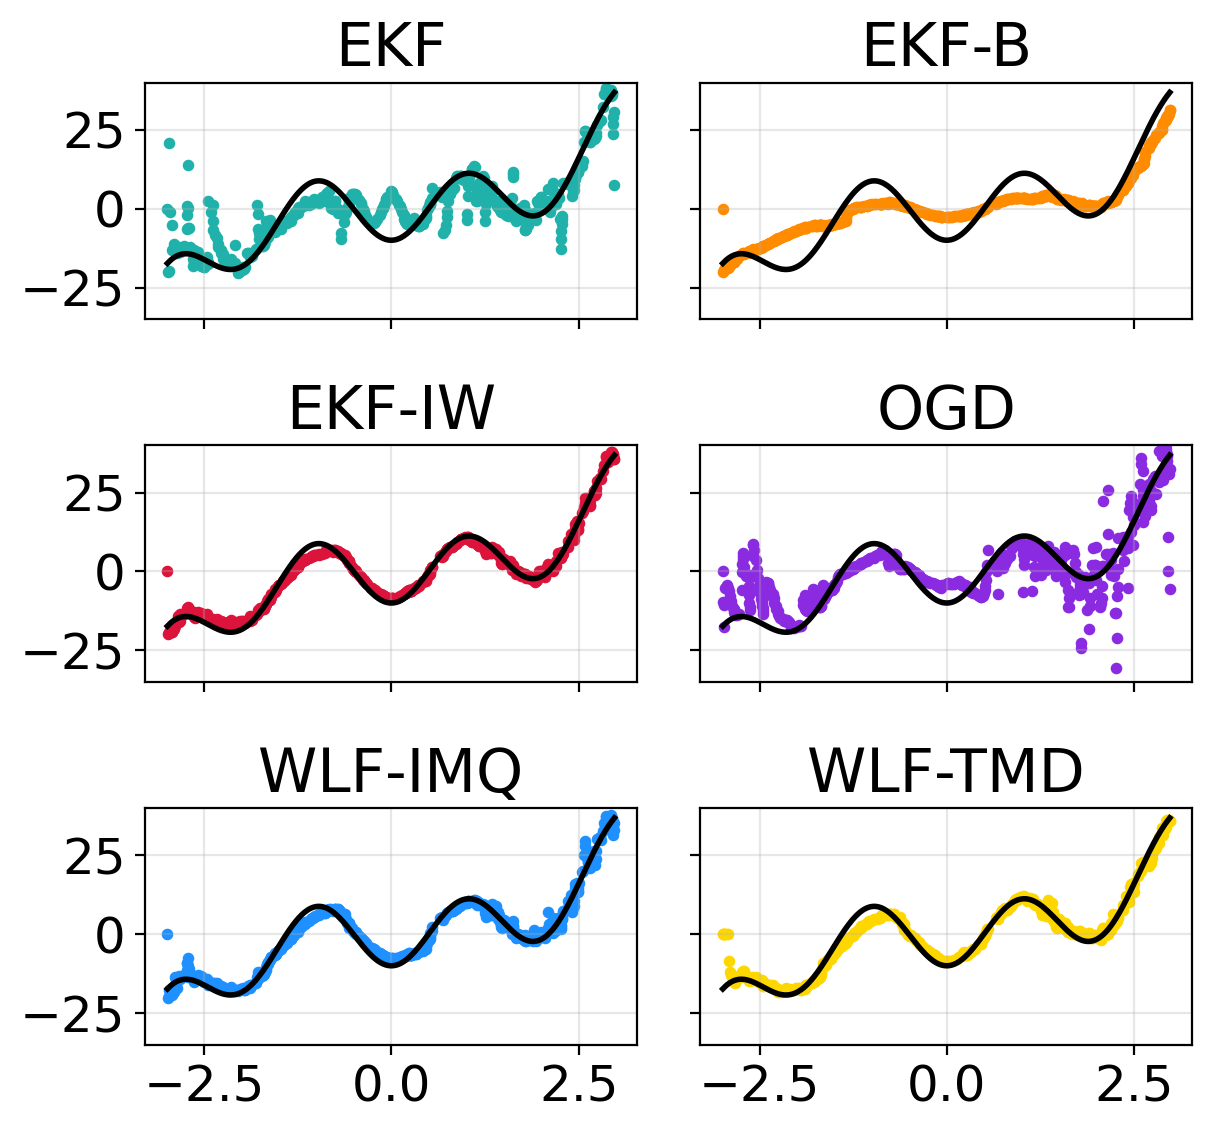

In [153]:
fig, axs = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(6.4, 4.8 * 2.5 / 2))
axs = axs.ravel()

# for ax, method in zip(axs[1:], pp_elements):
for ax, method in zip(axs, pp_elements):
    c = cmap[method]
    ax.scatter(x, pp_elements[method], c=c, s=10)
    ax.set_ylim(-35, 40)
    ax.grid(alpha=0.3)
    ax.plot(xtest, ytest, c="black", linewidth=2)
    
    method_new = method.replace("-MD", "-TMD")
    
    ax.set_title(method_new)

# axs[0].scatter(x, y, edgecolors="tab:gray", color="none")
# axs[0].grid(alpha=0.3)
# axs[0].plot(xtest, ytest, c="black", linewidth=2)
# axs[0].set_title("(Measurements)")


plt.tight_layout()
plt.savefig(f"./figures/online-{model_str}-{is_sorted_str}-sample.png", dpi=300)

## Multiple runs

In [169]:
ytest = f(xtest)
n_obs = 1500
@jax.jit
@jax.vmap
def sample_and_eval(key):
    key_train, key_sample_obs, key_eval = jax.random.split(key, 3)
    x, y = sample_observations_grid(key_sample_obs, f, n_obs, xmin, xmax, x_noise=0.1, y_noise=sigma_y)
    params_init = model.init(key_train, x[:, None])
    
    bel_init = agent_ekf.init_bel(params_init, cov=lr_ekf)
    callback = partial(callback_fn, applyfn=agent_ekf.vobs_fn)
    bel_ekf, ekf_hist = agent_ekf.scan(bel_init, y, x[:, None], callback_fn=callback)
    yhat_ekf = agent_ekf.vobs_fn(bel_ekf.mean, xtest[:, None]).ravel()
    
    bel_init = agent_rekf.init_bel(params_init, cov=lr_rkef)
    callback = partial(callback_fn, applyfn=agent_rekf.vobs_fn)
    bel_rekf, rekf_hist = agent_rekf.scan(bel_init, y, x[:, None], callback_fn=callback)
    yhat_rekf = agent_rekf.vobs_fn(bel_rekf.mean, xtest[:, None]).ravel()

    bel_init = agent_imq.init_bel(params_init, cov=lr_imq)
    callback = partial(callback_fn, applyfn=agent_imq.link_fn)
    bel_imq, imq_hist = agent_imq.scan(bel_init, y, x[:, None], callback_fn=callback)
    yhat_imq = agent_imq.link_fn(bel_imq.mean, xtest[:, None]).ravel()
    
    
    bel_init = agent_mekf.init_bel(params_init, cov=lr_mekf)
    callback = partial(callback_fn, applyfn=agent_mekf.vobs_fn)
    bel_mekf, mekf_hist = agent_mekf.scan(bel_init, y, x[:, None], callback_fn=callback)
    yhat_mekf = agent_mekf.vobs_fn(bel_mekf.mean, xtest[:, None]).ravel()
    
    bel_init = agent_oekf.init_bel(params_init, cov=lr_oekf)
    callback = partial(callback_fn, applyfn=agent_oekf.vobs_fn)
    bel_oekf, oekf_hist = agent_oekf.scan(bel_init, y, x[:, None], callback_fn=callback)
    
    bel_init = agent_ogd.init_bel(params_init)
    callback = partial(callback_fn, applyfn=agent_ogd.apply_fn)
    bel_ogd, ogd_hist = agent_ogd.scan(bel_init, y, x[:, None], callback_fn=callback)
    # yhat_ogd = agent_mekf.vobs_fn(bel_mekf.mean, xtest[:, None]).ravel()



    errs = {
        "EKF-IW": yhat_rekf,
        "WLF-IMQ": yhat_imq,
        "EKF": yhat_ekf,
        "WLF-MD": yhat_mekf,
    }
    
    
    # One-step-ahead errors
    errs_osa = {
        "EKF-IW": rekf_hist,
        "WLF-IMQ": imq_hist,
        "EKF": ekf_hist,
        "WLF-MD": mekf_hist,
        "OGD": ogd_hist,
        "EKF-B": oekf_hist,
    }
    errs_osa = jax.tree_map(lambda yhat: yhat.squeeze() - y, errs_osa)
        
    
    errs = jax.tree_map(lambda yhat: jnp.sqrt(jnp.power(yhat - ytest, 2).mean()), errs)
    
    return errs, errs_osa

In [170]:
from jax.sharding import PositionalSharding
devices = jax.devices()
sharding = PositionalSharding(devices)

In [171]:
%%time
n_sims = 104
keys = jax.random.split(key_eval, n_sims)
keys = jax.device_put(keys, sharding.reshape(4, 2))

results, errs_osa = sample_and_eval(keys)
results = jax.tree_map(np.array, results)
errs_osa = jax.tree_map(lambda x: np.array(x.squeeze()), errs_osa)
results_df = pd.DataFrame(results)

CPU times: user 8.6 s, sys: 156 ms, total: 8.76 s
Wall time: 7.01 s


In [172]:
def running_mean(errs):
    errs = errs[:, 0:]
    _, nsteps = errs.shape
    # return np.sqrt(np.power(errs, 2).cumsum(axis=1) / np.arange(1, nsteps + 1)[None])
    return jnp.sqrt(np.power(errs, 2).cumsum(axis=1))

errs_rmean = jax.tree_map(running_mean, errs_osa)

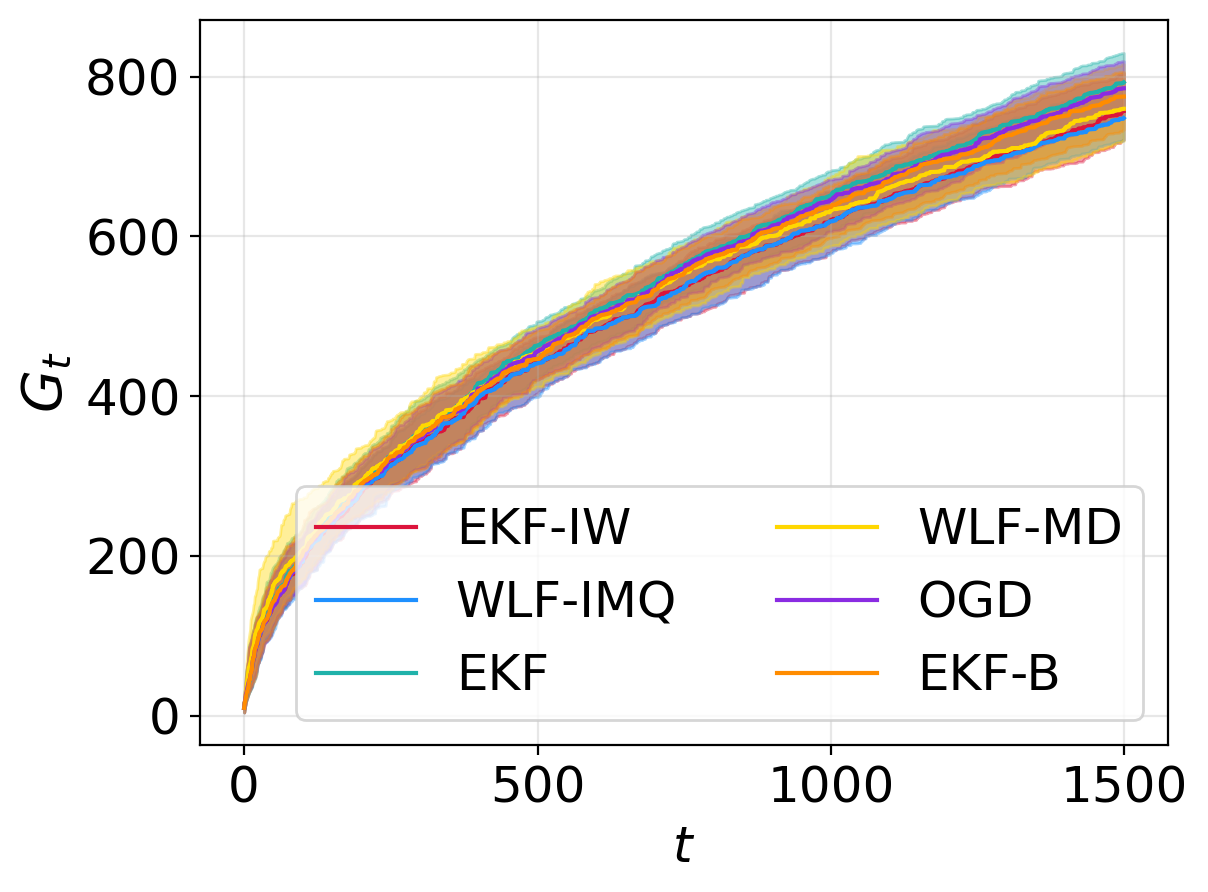

In [173]:
for method in cmap:
    plt.plot(np.nanquantile(errs_rmean[method], 0.5, axis=0), c=cmap[method], label=method)
    vmin, vmax = np.nanquantile(errs_rmean[method], [0.2, 0.8], axis=0)
    plt.fill_between(np.arange(len(vmin)), vmin, vmax, color=cmap[method], alpha=0.4)

# plt.yscale("log")
plt.legend(ncol=2, loc="lower right")
plt.grid(alpha=0.3)
plt.xlabel("$t$")
plt.ylabel("$G_t$", fontsize=20)
plt.tight_layout()
ymin, _ = plt.ylim()
# plt.ylim(ymin, 800)
# plt.savefig(f"./figures/online-{model_str}-{is_sorted_str}-osa-benchmark.pdf")

In [174]:
results_osa_df = jax.tree_map(lambda errs: jnp.sqrt(jnp.median(jnp.power(errs, 2)[:, 0:], axis=1)), errs_osa)
results_osa_df = pd.DataFrame(results_osa_df)
results_osa_df.describe()

,EKF,EKF-B,EKF-IW,OGD,WLF-IMQ,WLF-MD
count,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000
mean,7.139975,7.109618,4.764476,7.175006,4.725689,4.428210
std,0.495291,3.472856,2.120258,0.350402,1.999348,1.997247
min,5.375397,3.319690,2.379888,5.934022,2.462511,2.444850
25%,6.911008,5.808626,2.553710,7.065131,2.756188,2.685107
50%,7.272111,7.068148,6.125523,7.257348,3.794160,3.406699
75%,7.521481,7.290570,6.836256,7.380039,6.982712,6.945110
max,8.029343,25.909845,7.500093,7.746552,7.483525,7.581621


In [175]:
def format_entry(entry):
    entry = entry[entry < 1000]
    mean = entry.mean()
    std = entry.std()
    if std > 1000:
        label = rf"$-$"
    else:
        label = rf"${mean:0.3f} \pm {std:0.3f}$"
    return label

In [176]:
res = results_osa_df.melt().groupby("variable")["value"].apply(format_entry)
res

variable
EKF        $7.140 \pm 0.495$
EKF-B      $7.110 \pm 3.473$
EKF-IW     $4.764 \pm 2.120$
OGD        $7.175 \pm 0.350$
WLF-IMQ    $4.726 \pm 1.999$
WLF-MD     $4.428 \pm 1.997$
Name: value, dtype: object

In [177]:
model_str, is_sorted_str

('dgen', 'unsorted')

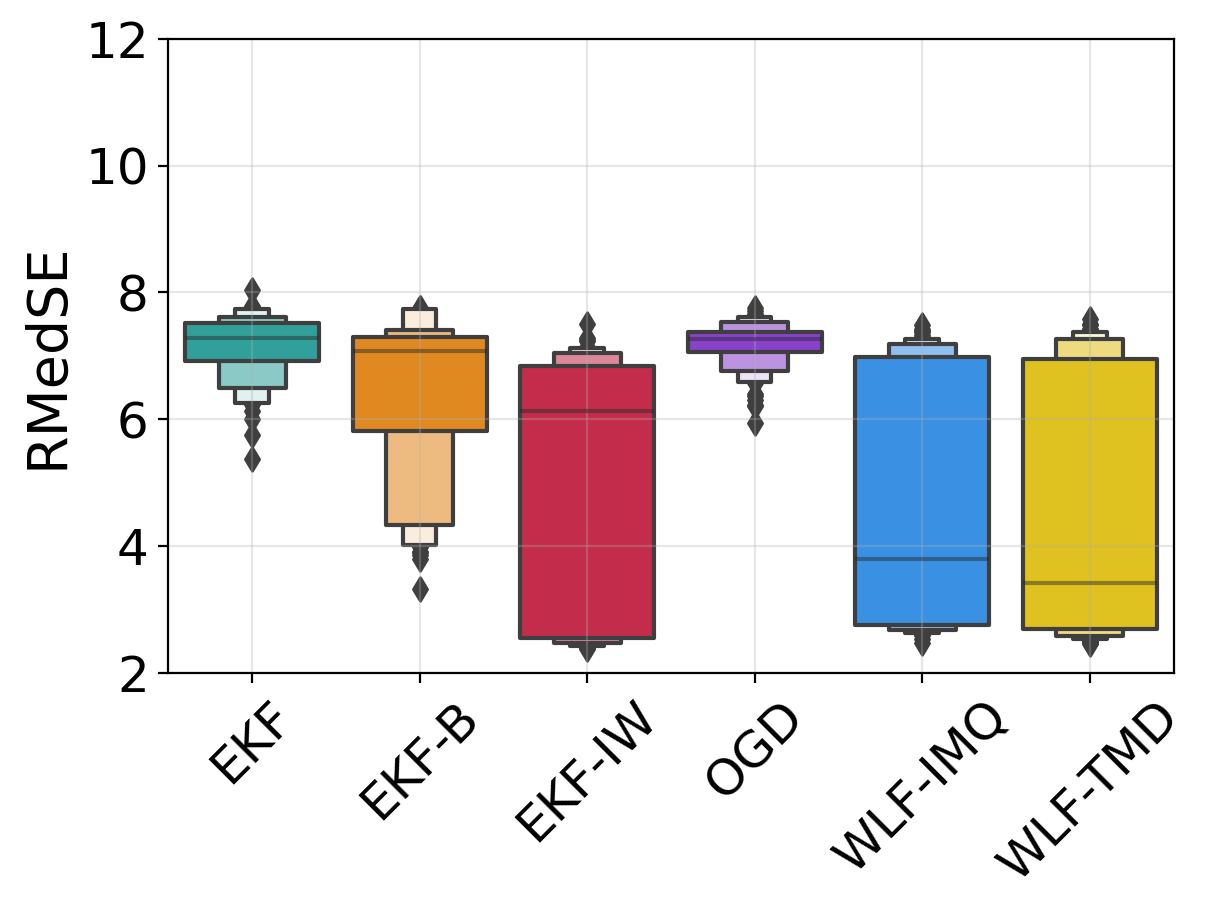

In [178]:
p = sns.boxenplot(
    (
    results_osa_df
        .melt()
        # .query("value < 1000")
    )
    ,
    x="variable", y="value",
    palette=cmap
)

plt.grid(alpha=0.3)
# plt.yscale("log")
plt.xlabel("")
plt.ylabel("RMedSE", fontsize=20)

loc, labels = plt.xticks()
labels = [l.get_text().replace("-MD", "-TMD") for l in labels]
plt.xticks(ticks=loc, labels=labels, rotation=45)


plt.tight_layout()
# plt.yscale("log")
plt.ylim(bottom=2.0, top=12)
plt.savefig(f"./figures/online-{model_str}-{is_sorted_str}-benchmark.png", dpi=300)

## Animation


In [154]:
from matplotlib.animation import FuncAnimation

In [155]:
x_cpu = np.array(x)
y_cpu = np.array(y)

xtest_cpu = np.array(xtest)
ytest_cpu = np.array(ytest)

pp_elements_short = pp_elements.copy()
del pp_elements_short["WLF-MD"]

MovieWriter ffmpeg unavailable; using Pillow instead.


/tmp/ipykernel_2614921/4065620406.py:22: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


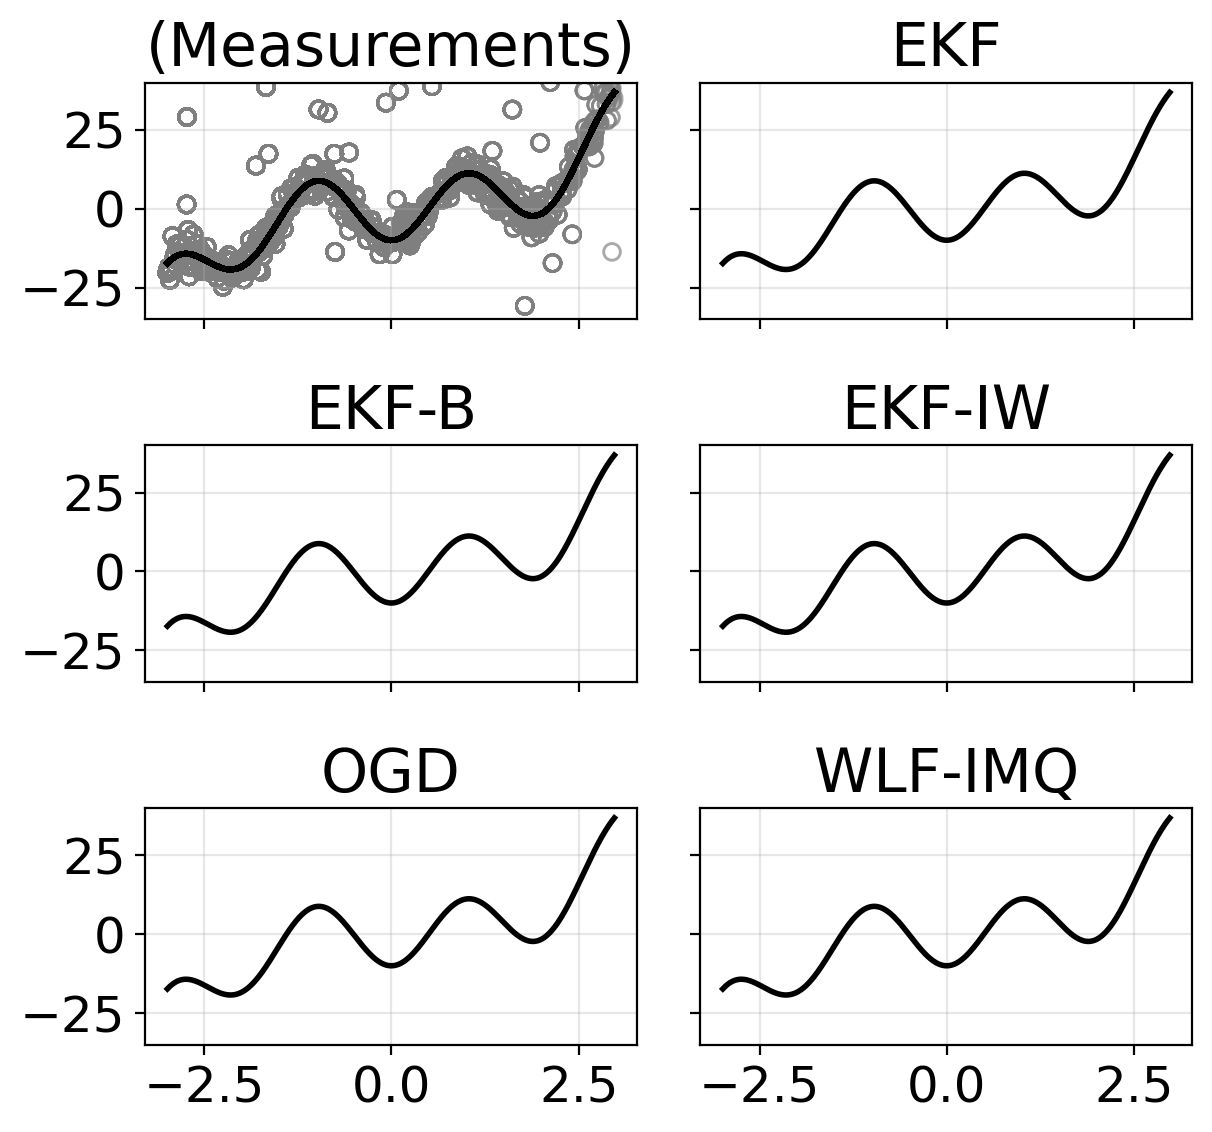

In [156]:
fig, axs = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(6.4, 4.8 * 2.5 / 2))
axs = axs.ravel()

def step(t):
    print(f"At step {t}", end="\r")
    for ax, method in zip(axs[1:], pp_elements):
        ax.cla()
        c = cmap[method]
        tinit = max(0, t - 100)
        tinit = 0
        tslice = slice(0, t)
        ax.scatter(x_cpu[tslice], pp_elements[method][tslice], c=c, s=10)
        ax.set_ylim(-35, 40)
        ax.grid(alpha=0.3)
        ax.plot(xtest_cpu, ytest_cpu, c="black", linewidth=2)

        method_new = method.replace("-MD", "-TMD")

        ax.set_title(method_new)

    axs[0].scatter(x_cpu[tinit:t], y_cpu[tinit:t], edgecolors="tab:gray", color="none", alpha=0.3)
    plt.tight_layout()
    axs[0].grid(alpha=0.3)
    axs[0].plot(xtest, ytest, c="black", linewidth=2)
    axs[0].set_title("(Measurements)")

animation = FuncAnimation(fig, step, frames=np.arange(0, 503, 3))
animation.save(f"./live-online-{model_str}-{is_sorted_str}-sample.gif", fps=15, dpi=70)

# plt.savefig(f"./figures/online-{model_str}-{is_sorted_str}-sample.png", dpi=300)